In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/lgetker/conda-envs/my-clone/share/proj failed


In [2]:
"""
Start by loading data
"""
#ds = xr.open_dataset("/scratch/legetker/floor_only_200000_data.nc")
ds = xr.open_dataset("/glade/work/lgetker/detected_hws/98_per_200000_hit_min_and_floor_data.nc")
#ds = xr.open_dataset("/glade/work/lgetker/detected_hws/hw_98_per_max_only_90f_floor_100000_data.nc")
print(ds)
#field = ds['climate_data'].values
field = ds['climate_data'].values
print(field.shape)
sub_lats = ds['lat'].values
sub_lons = ds['lon'].values
dates = ds['time'].values
dates = dates.astype('datetime64[s]')
areas = ds['area'].values
cent_lats = ds['centroid_lats'].values
cent_lons = ds['centroid_lons'].values
field_zeroes = np.nan_to_num(field)
print("# of masks: " + str(dates.shape))
print("unique hw days: " + str(np.unique(dates).shape))

<xarray.Dataset>
Dimensions:        (time: 461, lat: 259, lon: 559)
Coordinates:
  * time           (time) datetime64[ns] 1941-06-24T23:00:00 ... 2022-08-07T2...
  * lat            (lat) float64 74.75 74.5 74.25 74.0 ... 11.0 10.75 10.5 10.25
  * lon            (lon) float64 -179.8 -179.5 -179.2 ... -40.75 -40.5 -40.25
Data variables:
    climate_data   (time, lat, lon) float64 ...
    area           (time) float64 ...
    centroid_lats  (time) float64 ...
    centroid_lons  (time) float64 ...
Attributes:
    description:  Heat wave masks
    units:        degC
(461, 259, 559)
# of masks: (461,)
unique hw days: (443,)


In [3]:
"""
Convert dates to timestamp
"""
pd_dates = np.zeros_like(dates)
for i in range(len(dates)):
    pd_dates[i] = pd.Timestamp(dates[i])
    #print(dates[i])

In [4]:
"""
Save out dates for SOM training
"""
np.save("98_200000km_hws_dates", pd_dates)

In [5]:
"""
Find non-unique HW dates
"""
from collections import Counter
def find_repeated_values(arr):
    counts = Counter(arr)
    repeated_values = [item for item, count in counts.items() if count > 1]
    return repeated_values
repeated_values = find_repeated_values(pd_dates)
print(repeated_values)

[numpy.datetime64('1952-06-26T23:00:00'), numpy.datetime64('1973-08-27T23:00:00'), numpy.datetime64('1980-07-09T23:00:00'), numpy.datetime64('1983-07-21T23:00:00'), numpy.datetime64('1995-06-19T23:00:00'), numpy.datetime64('2001-08-05T23:00:00'), numpy.datetime64('2002-07-13T23:00:00'), numpy.datetime64('2002-07-14T23:00:00'), numpy.datetime64('2011-07-18T23:00:00'), numpy.datetime64('2011-08-01T23:00:00'), numpy.datetime64('2015-08-15T23:00:00'), numpy.datetime64('2016-08-12T23:00:00'), numpy.datetime64('2019-07-20T23:00:00'), numpy.datetime64('2019-08-11T23:00:00'), numpy.datetime64('2019-08-13T23:00:00'), numpy.datetime64('2021-06-27T23:00:00'), numpy.datetime64('2021-06-29T23:00:00'), numpy.datetime64('2022-06-12T23:00:00')]


In [6]:
"""
Animation
"""
for i in range(len(field)):
    idx = i
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
    ax.add_feature(cfeature.STATES)
    ax.coastlines()
    cf = ax.contourf(sub_lons, sub_lats, field[idx], cmap='turbo',transform=ccrs.PlateCarree(), levels = np.arange(32, 49, 1))
    ax.scatter(cent_lons[idx], cent_lats[idx], color = 'r',transform=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=1, color='gray')
    cbar = plt.colorbar(cf)
    cbar.ax.set_ylabel("max(HI,T) (degrees C)",fontsize =14)
    gl.top_labels=False   # suppress top labels
    gl.right_labels=False # suppress right labels
    ax.set_extent([-130, -60, 10, 60])
    plt.title(pd_dates[idx], fontsize=16)
    if i < 10:
        plt.savefig("plots/00" + str(i) + "hw_fig", bbox_inches = 'tight')
    elif i >= 10 and i < 100:
        plt.savefig("plots/0" + str(i) + "hw_fig", bbox_inches = 'tight')
    else:
        plt.savefig("plots/" + str(i) + "hw_fig", bbox_inches = 'tight')
    plt.close()

In [7]:
import imageio
import glob
images = []
all_imgs = sorted(glob.glob("plots/*"))
for i in range(len(all_imgs)):
    images.append(imageio.imread(all_imgs[i]))
imageio.mimsave('hws.gif', images, duration=.5)

/glade/derecho/scratch/lgetker/tmp/ipykernel_202259/3719952226.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(all_imgs[i]))


(array([430, 431]),)
430
2021-06-29T23:00:00


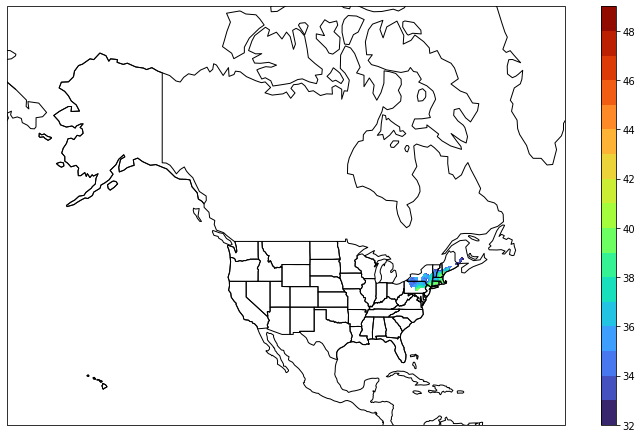

In [8]:
"""
Look at individual masks
"""
date = pd.Timestamp(2021, 6, 29, 23)
idxs = np.where(pd_dates == date)
print(idxs)
idx = idxs[0][0]
print(idx)
print(dates[idx])
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator(central_longitude = 0))
ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
#ax.set_extent([wlon, elon, slat, nlat], crs=ccrs.PlateCarree())
cs = ax.contourf(sub_lons, sub_lats, field[idx,:,:], cmap = "turbo", transform=ccrs.PlateCarree(), levels = np.arange(32, 50, 1))
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
plt.colorbar(cs, cax = cax)

<xarray.Dataset>
Dimensions:     (lat: 259, lon: 559)
Coordinates:
  * lon         (lon) float64 180.2 180.5 180.8 181.0 ... 319.2 319.5 319.8
  * lat         (lat) float64 74.75 74.5 74.25 74.0 ... 11.0 10.75 10.5 10.25
    time        datetime64[ns] 2021-06-29T23:00:00
Data variables:
    temp_or_hi  (lat, lon) float64 ...
Attributes:
    description:  Arrays containing either daily max heat index or daily max ...
    units:        degC


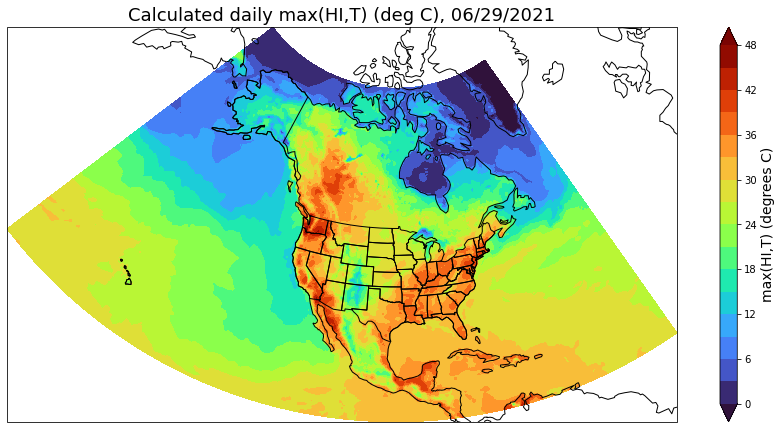

In [9]:
"""
Plot a hit field
"""
hit_ds = xr.open_dataset("/glade/work/lgetker/daily_max_hi_or_temp/2021_daily_max_hi_or_temp_MJJAS_NA.nc")
hit_ds_sub = hit_ds.sel(time=pd.Timestamp(2021, 6, 29, 23))
print(hit_ds_sub)
hit_vals = hit_ds_sub['temp_or_hi'].values
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
#ax.set_extent([-130, -60, 10, 60], crs=ccrs.PlateCarree())
cs = ax.contourf(sub_lons, sub_lats, hit_vals, cmap = "turbo", transform=ccrs.PlateCarree(), levels = np.arange(0, 50, 3), extend = 'both')
plt.title("Calculated daily max(HI,T) (deg C), 06/29/2021", fontsize=18)
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
cbar = plt.colorbar(cs, cax = cax)
cbar.ax.set_ylabel("max(HI,T) (degrees C)",fontsize =14)
plt.savefig("HIT_2021_6_29.png")

[[], [], [], [], [], [], [], [], []]
0.9333333333333333
R-squared: 0.742068


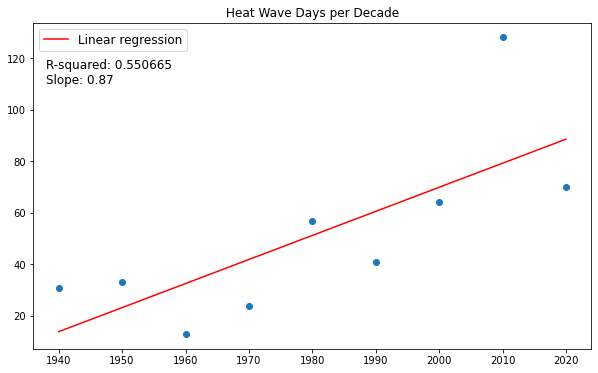

In [10]:
"""
Bin HW dates by decade, then perform linear regression to identify trends.
"""
from scipy import stats
decades_str = ['1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
decades_int = [1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0, 2000.0, 2010.0, 2020.0]
decades = [[],[],[],[],[],[],[],[],[]]
print(decades)
for i in range(len(pd_dates)):
    year = pd.Timestamp(pd_dates[i]).year
    if year >= 1940 and year < 1950:
        decades[0].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    elif year >= 1950 and year < 1960:
        decades[1].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    elif year >= 1960 and year < 1970:
        decades[2].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    elif year >= 1970 and year < 1980:
        decades[3].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    elif year >= 1980 and year < 1990:
        decades[4].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    elif year >= 1990 and year < 2000:
        decades[5].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    elif year >= 2000 and year < 2010:
        decades[6].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    elif year >= 2010 and year < 2020:
        decades[7].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    else: 
        decades[8].append(pd.Timestamp(pd_dates[i]).to_julian_date())
decades_freq = [len(decades[0]), len(decades[1]), len(decades[2]), len(decades[3]), len(decades[4]), len(decades[5]), len(decades[6]), len(decades[7]), len(decades[8])]
fig = plt.figure(figsize = [10,6])
plt.scatter(decades_int, decades_freq)
res = stats.linregress(decades_int, decades_freq)
print(res.slope)
print(f"R-squared: {res.rvalue:.6f}")
plt.text(1938, 116, f"R-squared: {res.rvalue**2:.6f}", fontsize=12)
plt.text(1938, 110, f"Slope: {res.slope**2:.2f}", fontsize=12)
decades_int = np.array(decades_int)
plt.plot(decades_int, res.intercept + res.slope*decades_int, 'r', label='Linear regression')
plt.title("Heat Wave Days per Decade")
plt.legend(fontsize = 12)
plt.show()

R-squared: 0.4
4.2


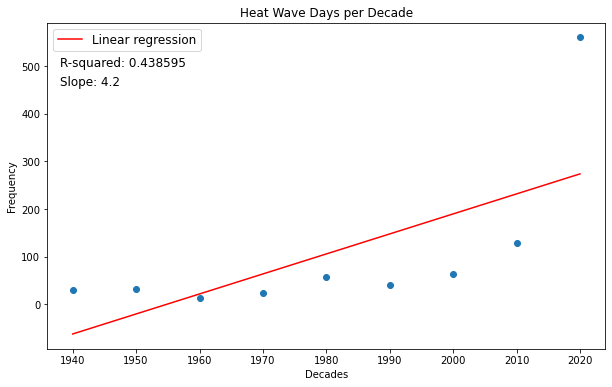

In [11]:
"""
Same as before, but now extrapolate HW frequencies throughout the 2020s
"""
decades_freq = [len(decades[0]), len(decades[1]), len(decades[2]), len(decades[3]), len(decades[4]), len(decades[5]), len(decades[6]), len(decades[7]), len(decades[8])]
decades_freq[8] = decades_freq[8] + decades_freq[8] * 7
fig = plt.figure(figsize = [10,6])
plt.scatter(decades_int, decades_freq)
res = stats.linregress(decades_int, decades_freq)
print(f"R-squared: {res.rvalue**2:.1f}")
print(res.slope)
plt.text(1938, 500, f"R-squared: {res.rvalue**2:.6f}", fontsize=12)
plt.text(1938, 460, f"Slope: {res.slope:.1f}", fontsize=12)
decades_int = np.array(decades_int)
plt.plot(decades_int, res.intercept + res.slope*decades_int, 'r', label='Linear regression')
plt.title("Heat Wave Days per Decade")
plt.legend(fontsize=12)
plt.ylabel("Frequency")
plt.xlabel("Decades")
plt.show()

[36.3526599742896, 38.32289334361114, 36.78116146605347, 35.75127021774386, 38.490857815856764, 38.52451537614175, 36.697935756030965, 39.693127367500516, 37.6168032854865]
R-squared: 0.2
0.019623448424680986


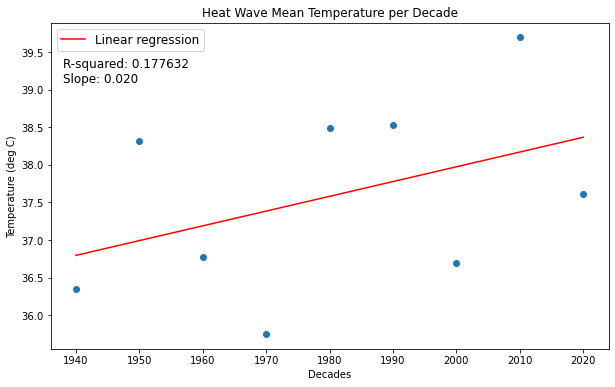

In [12]:
"""
Same as before, but for mean HW magnitude trends
"""
magnitude = np.nanmean(field, axis = (1,2))
decades_temp = [[],[],[],[],[],[],[],[],[]]
for i in range(len(pd_dates)):
    year = pd.Timestamp(pd_dates[i]).year
    if year >= 1940 and year < 1950:
        decades_temp[0].append(magnitude[i])
    elif year >= 1950 and year < 1960:
        decades_temp[1].append(magnitude[i])
    elif year >= 1960 and year < 1970:
        decades_temp[2].append(magnitude[i])
    elif year >= 1970 and year < 1980:
        decades_temp[3].append(magnitude[i])
    elif year >= 1980 and year < 1990:
        decades_temp[4].append(magnitude[i])
    elif year >= 1990 and year < 2000:
        decades_temp[5].append(magnitude[i])
    elif year >= 2000 and year < 2010:
        decades_temp[6].append(magnitude[i])
    elif year >= 2010 and year < 2020:
        decades_temp[7].append(magnitude[i])
    else: 
        decades_temp[8].append(magnitude[i])
temp_mean = [np.mean(decades_temp[0]), np.mean(decades_temp[1]), np.mean(decades_temp[2]), np.mean(decades_temp[3]), np.mean(decades_temp[4]), np.mean(decades_temp[5]), np.mean(decades_temp[6]), np.mean(decades_temp[7]), np.mean(decades_temp[8])]
print(temp_mean)

fig = plt.figure(figsize = [10,6])
plt.scatter(decades_int, temp_mean)
res = stats.linregress(decades_int, temp_mean)
print(f"R-squared: {res.rvalue**2:.1f}")
print(res.slope)
plt.text(1938, 39.3, f"R-squared: {res.rvalue**2:.6f}", fontsize=12)
plt.text(1938, 39.1, f"Slope: {res.slope:.3f}", fontsize=12)
decades_int = np.array(decades_int)
plt.plot(decades_int, res.intercept + res.slope*decades_int, 'r', label='Linear regression')
plt.title("Heat Wave Mean Temperature per Decade")
plt.ylabel("Temperature (deg C)")
plt.xlabel("Decades")
plt.legend(fontsize=12)
plt.show()

[398353.2185383351, 383115.5167121852, 294809.5371907726, 372017.13932894025, 373956.6281532242, 459232.83082657633, 455658.19132896315, 408354.1868175696, 537069.1873232388]
R-squared: 0.5
1732.4881420496422


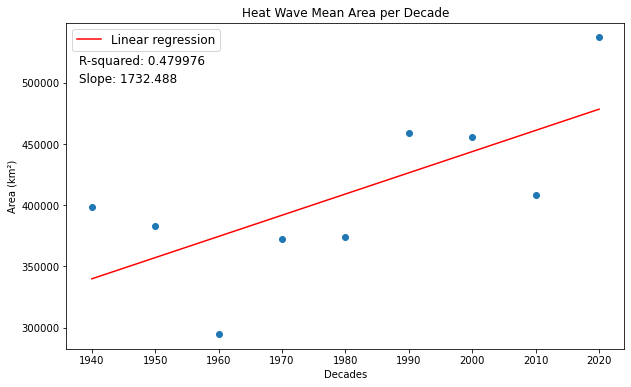

In [13]:
"""
Same as before, but for mean HW area trends
"""
area_vals = areas
decades_areas = [[],[],[],[],[],[],[],[],[]]
for i in range(len(pd_dates)):
    year = pd.Timestamp(pd_dates[i]).year
    if year >= 1940 and year < 1950:
        decades_areas[0].append(area_vals[i])
    elif year >= 1950 and year < 1960:
        decades_areas[1].append(area_vals[i])
    elif year >= 1960 and year < 1970:
        decades_areas[2].append(area_vals[i])
    elif year >= 1970 and year < 1980:
        decades_areas[3].append(area_vals[i])
    elif year >= 1980 and year < 1990:
        decades_areas[4].append(area_vals[i])
    elif year >= 1990 and year < 2000:
        decades_areas[5].append(area_vals[i])
    elif year >= 2000 and year < 2010:
        decades_areas[6].append(area_vals[i])
    elif year >= 2010 and year < 2020:
        decades_areas[7].append(area_vals[i])
    else: 
        decades_areas[8].append(area_vals[i])
area_mean = [np.mean(decades_areas[0]), np.mean(decades_areas[1]), np.mean(decades_areas[2]), np.mean(decades_areas[3]), np.mean(decades_areas[4]), np.mean(decades_areas[5]), np.mean(decades_areas[6]), np.mean(decades_areas[7]), np.mean(decades_areas[8])]
print(area_mean)

fig = plt.figure(figsize = [10,6])
plt.scatter(decades_int, area_mean)
res = stats.linregress(decades_int, area_mean)
print(f"R-squared: {res.rvalue**2:.1f}")
print(res.slope)
plt.text(1938, 515000, f"R-squared: {res.rvalue**2:.6f}", fontsize=12)
plt.text(1938, 500000, f"Slope: {res.slope:.3f}", fontsize=12)
decades_int = np.array(decades_int)
plt.plot(decades_int, res.intercept + res.slope*decades_int, 'r', label='Linear regression')
plt.title("Heat Wave Mean Area per Decade")
plt.legend(fontsize=12)
plt.ylabel("Area (km\u00b2)")
plt.xlabel("Decades")
plt.show()

Text(0.5, 1.0, 'Heat Wave Day Frequency by Location, 1940 - 2022')

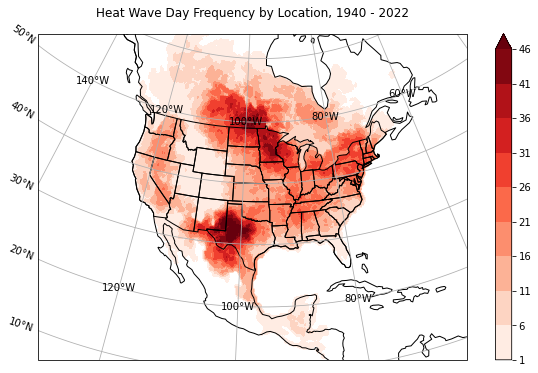

In [30]:
""" hw day frequency per cell """
hw_grid= np.zeros([field.shape[0], field.shape[1], field.shape[2]])
hw_grid[np.where(field > 0)] = 1
freq = np.sum(hw_grid, axis = 0)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
ax.add_feature(cfeature.STATES)
ax.coastlines()
ax.set_extent([-130, -65, 10, 60])
gl = ax.gridlines(draw_labels=True, dms=True)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels
cf = ax.contourf(sub_lons, sub_lats, freq, cmap='Reds',levels=np.arange(1,50, 5), extend = 'max', transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf)
plt.title("Heat Wave Day Frequency by Location, 1940 - 2022")

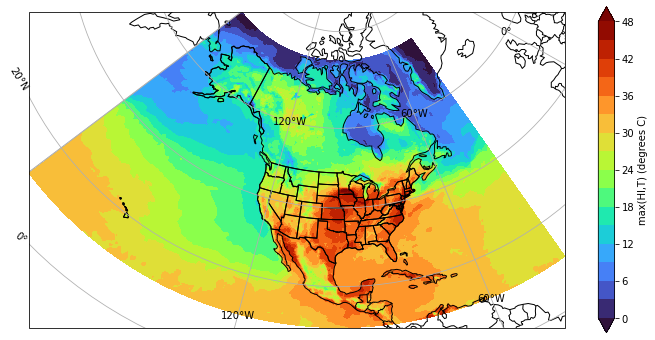

In [15]:
"""
Looking at HW identification process
"""
hit_ds = xr.open_dataset("/glade/work/lgetker/daily_max_hi_or_temp/2019_daily_max_hi_or_temp_MJJAS_NA.nc")
hit_ds = hit_ds.sel(time = pd.Timestamp(2019, 7, 20, 23))
hit = hit_ds['temp_or_hi'].values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels
cf = ax.contourf(sub_lons, sub_lats, hit, cmap = 'turbo', transform=ccrs.PlateCarree(), levels = np.arange(0, 51, 3), extend = 'both')
cbar = plt.colorbar(cf)
cbar.ax.set_ylabel("max(HI,T) (degrees C)")
#ax.set_extent([-130, -60, 20, 50])
plt.show()
fig.savefig("hit_field_fig_20190720.png", bbox_inches = 'tight')


<xarray.Dataset>
Dimensions:            (lat: 259, lon: 559)
Coordinates:
    time               datetime64[ns] 2000-07-20
  * lat                (lat) float64 74.75 74.5 74.25 74.0 ... 10.75 10.5 10.25
  * lon                (lon) float64 180.2 180.5 180.8 ... 319.2 319.5 319.8
Data variables:
    max_hi_or_temp_98  (lat, lon) float64 ...


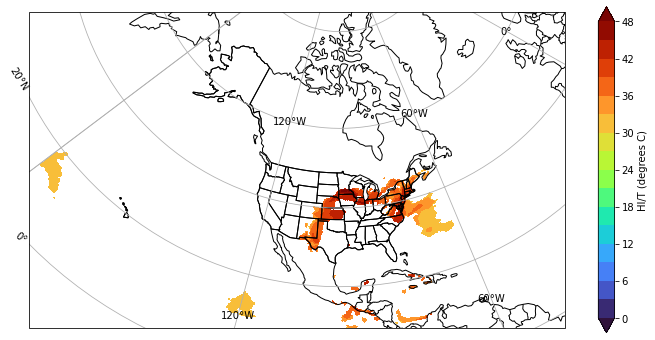

In [16]:
per_ds = xr.open_dataset("/glade/work/lgetker/daily_percentiles_NA/daily_98th_per_max_hi_or_temp_NA.nc")
per_ds = per_ds.sel(time=pd.Timestamp(2000, 7, 20, 0))
print(per_ds)
per_field = per_ds['max_hi_or_temp_98'].values

min_ds = xr.open_dataset("/glade/work/lgetker/daily_percentiles_NA/daily_98th_per_min_hi_or_temp_NA.nc")
min_ds = min_ds.sel(time=pd.Timestamp(2000, 7, 20, 0))
min = min_ds['min_hi_or_temp_98'].values

mask = np.copy(hit)
mask[hit<per_field] = np.nan
mask[hit<min] = np.nan
mask[hit<32] = np.nan
#mask = mask[mask>32]
#print(mask.shape)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels
cf = ax.contourf(sub_lons, sub_lats, mask, cmap = 'turbo', transform=ccrs.PlateCarree(), levels = np.arange(0, 51, 3), extend = 'both')
cbar = plt.colorbar(cf)
cbar.ax.set_ylabel("HI/T (degrees C)")
#ax.set_extent([-130, -60, 20, 50])
plt.show()
fig.savefig("mask_fig_20190720.png", bbox_inches = 'tight')

(array([370, 371]),)


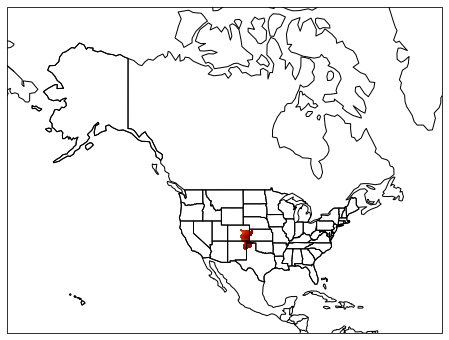

In [17]:
#numpy.datetime64('2019-07-20T23:00:00')
lons = sub_lons
lats = sub_lats
date = pd.Timestamp(2019, 7, 20, 23)
print(np.where(pd_dates == date))
test_field_one = field[np.where(pd_dates == date)[0][0]]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.coastlines()
ax.contourf(lons, lats, test_field_one, cmap='turbo', transform=ccrs.PlateCarree(), levels = np.arange(1,40,1))
#ax.set_extent([np.min(lons_sorted),np.max(lons_sorted), np.min(lats_sorted), np.max(lats_sorted)])
plt.show()
plt.close()


(array([370, 371]),)


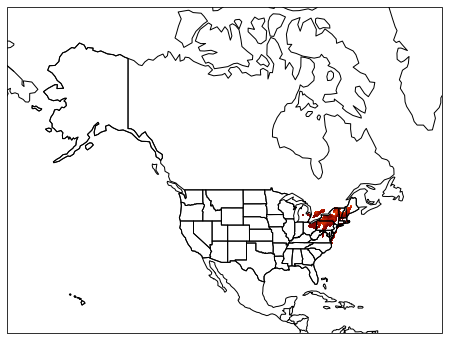

(259, 559)


In [18]:
from geopy.distance import geodesic
import cv2
date = pd.Timestamp(2019, 7, 20, 23)
print(np.where(pd_dates == date))
test_field_two = field[np.where(pd_dates == date)[0][1]]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

ax.coastlines()
ax.contourf(lons, lats, test_field_two, cmap='turbo', transform=ccrs.PlateCarree(), levels = np.arange(1,40,1))
#ax.set_extent([np.min(lons_sorted),np.max(lons_sorted), np.min(lats_sorted), np.max(lats_sorted)])
plt.show()
plt.close()

print(test_field_two.shape)

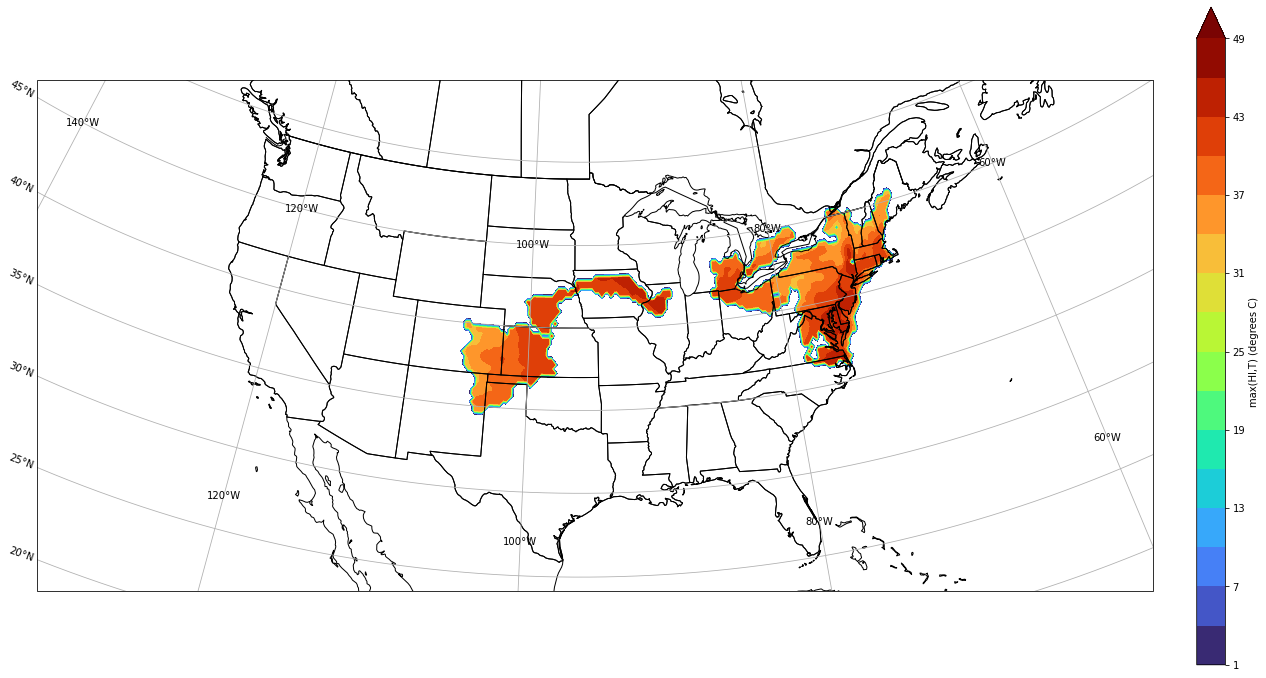

In [25]:
test_field_one[np.isnan(test_field_one)] = 0
test_field_two[np.isnan(test_field_two)] = 0
combined = np.add(test_field_one, test_field_two)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels
cf = ax.contourf(lons, lats, combined, cmap='turbo', transform=ccrs.PlateCarree(), levels = np.arange(1,51,3), extend = 'max')
cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
cbar = plt.colorbar(cf, cax = cax)
cbar.ax.set_ylabel("max(HI,T) (degrees C)")
ax.set_extent([-130, -60, 20, 50])
#plt.title("Heat Wave Extent and max(HI,T)")
fig.savefig("hw_masks_field_fig_20190720.png", bbox_inches = 'tight')

(67, 259, 559)
19.0
(45, 259, 559)
12.0
(65, 259, 559)
21.0
(38, 259, 559)
12.0
(40, 259, 559)
13.0
(29, 259, 559)
4.0
(71, 259, 559)
24.0
(41, 259, 559)
11.0
(65, 259, 559)
12.0


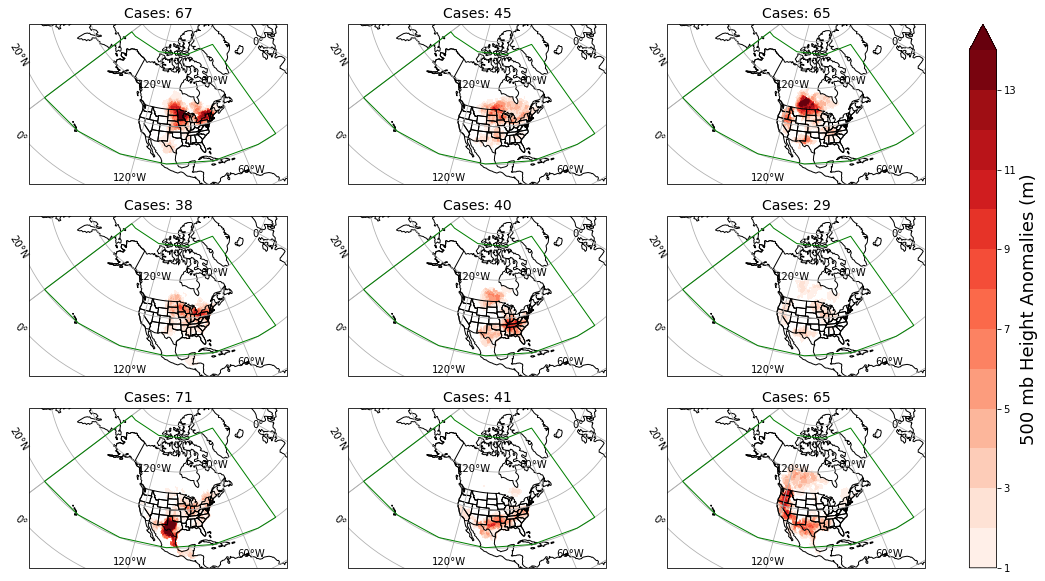

In [20]:
"""
HW frequency per SOM node--reades in files containing SOM node dates
"""
import matplotlib.patches as mpatches
fig, axs = plt.subplots(3, 3, subplot_kw={'projection': ccrs.LambertConformal()}, figsize=(20,10))  #Fig size may need to be changed to look nice.

for x in range(0,3):
    for y in range(0,3):
        #print("node_" + str(x) + "_" + str(y) + "_dates.npy")
        node_dates = np.load("node_" + str(x) + "_" + str(y) + "_dates.npy", allow_pickle = True)
        #print(x,y)
        #print(type(node_dates[0]))
        #print(type(all_dates[0]))
        node_masks = np.zeros([len(node_dates), 259, 559])
        for i in range(len(node_dates)):
            #print(np.where(pd_dates == node_dates[i])[0][0])
            #print(node_dates[i])
            node_masks[i,:,:] = field[np.where(pd_dates == node_dates[i])[0][0]]
        print(node_masks.shape)
        node_masks[np.where(node_masks > 0)] = 1
        node_masks[np.isnan(node_masks)] = 0
        freq = np.sum(node_masks, axis = 0)
        print(np.max(freq))
        #axs[x,y].set_extent([elon,wlon,slat,nlat],crs=ccrs.PlateCarree())
        axs[x,y].add_feature(cfeature.STATES, edgecolor='black')  #Add US states
        axs[x,y].add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
        gl = axs[x,y].gridlines(draw_labels=True, dms=True)
        gl.top_labels=False   # suppress top grid labels
        gl.right_labels=False # suppress right grid labels
        axs[x,y].set_title(f"Cases: {len(node_dates)}", fontsize = 14)  #set title
        axs[x,y].add_patch(mpatches.Rectangle(xy=[180, 20], width=140, height=55,
                        facecolor='none', edgecolor='g',zorder=10,
                        transform=ccrs.PlateCarree()))
        cs = axs[x,y].contourf(lons, lats, freq, cmap = 'Reds', transform=ccrs.PlateCarree(), levels = np.arange(1,15,1), extend = 'max')
cbar = plt.colorbar(cs,ax=fig.get_axes(), pad=0.04)
cbar.ax.set_ylabel("500 mb Height Anomalies (m)", fontsize = 18)
plt.savefig("node_frequency.png", bbox_inches = 'tight')

-0.06666666666666667
R-squared: -0.569495
0.08833333333333333
R-squared: 0.609558
0.020000000000000004
R-squared: 0.165563
0.04
R-squared: 0.459055
0.08833333333333333
R-squared: 0.504115
0.06999999999999999
R-squared: 0.640991
0.20999999999999996
R-squared: 0.537788
0.17666666666666667
R-squared: 0.705518
0.30666666666666664
R-squared: 0.799144


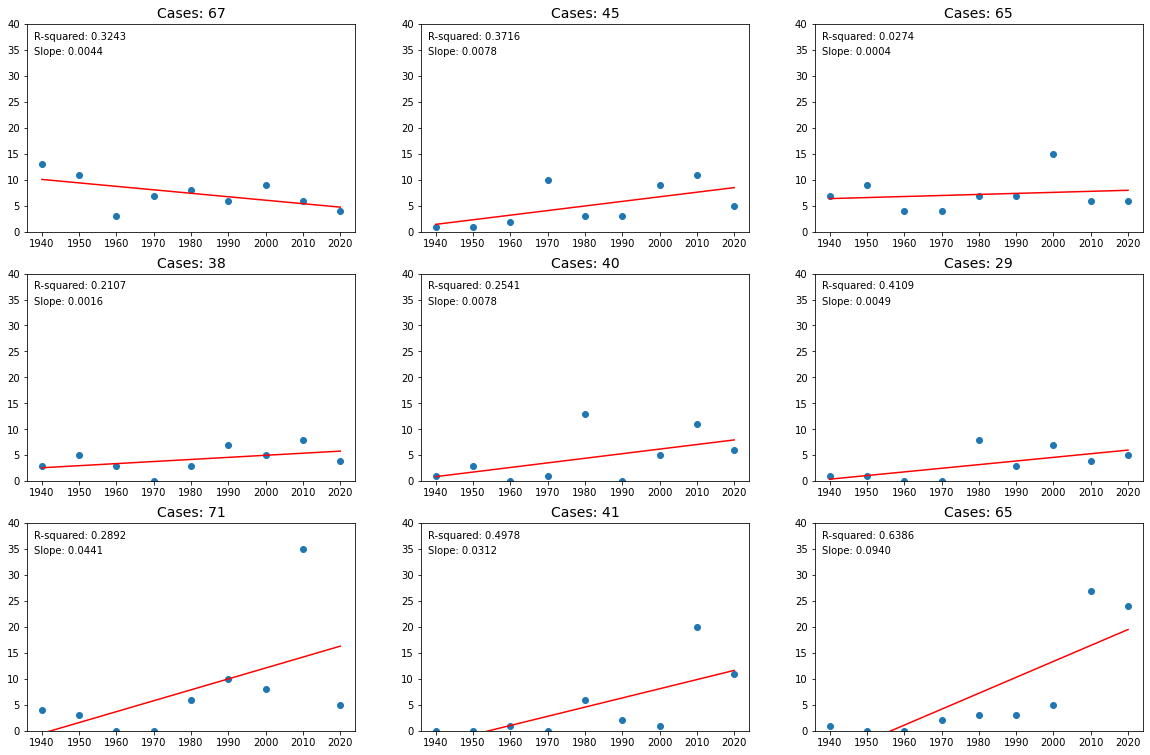

In [44]:
"""
HW trends per SOM node 
"""

fig, axs = plt.subplots(3, 3, figsize=(20,13))  #Fig size may need to be changed to look nice.

for x in range(0,3):
    for y in range(0,3):
        node_dates = np.load("node_" + str(x) + "_" + str(y) + "_dates.npy", allow_pickle = True)
        decades = [[],[],[],[],[],[],[],[],[]]
        for i in range(len(node_dates)):
            year = pd.Timestamp(node_dates[i]).year
            if year >= 1940 and year < 1950:
                decades[0].append(pd.Timestamp(node_dates[i]).to_julian_date())
            elif year >= 1950 and year < 1960:
                decades[1].append(pd.Timestamp(node_dates[i]).to_julian_date())
            elif year >= 1960 and year < 1970:
                decades[2].append(pd.Timestamp(node_dates[i]).to_julian_date())
            elif year >= 1970 and year < 1980:
                decades[3].append(pd.Timestamp(node_dates[i]).to_julian_date())
            elif year >= 1980 and year < 1990:
                decades[4].append(pd.Timestamp(node_dates[i]).to_julian_date())
            elif year >= 1990 and year < 2000:
                decades[5].append(pd.Timestamp(node_dates[i]).to_julian_date())
            elif year >= 2000 and year < 2010:
                decades[6].append(pd.Timestamp(node_dates[i]).to_julian_date())
            elif year >= 2010 and year < 2020:
                decades[7].append(pd.Timestamp(node_dates[i]).to_julian_date())
            else: 
                decades[8].append(pd.Timestamp(pd_dates[i]).to_julian_date())
    
        decades_freq = [len(decades[0]), len(decades[1]), len(decades[2]), len(decades[3]), len(decades[4]), len(decades[5]), len(decades[6]), len(decades[7]), len(decades[8])]
        axs[x,y].scatter(decades_int, decades_freq)
        res = stats.linregress(decades_int, decades_freq)
        print(res.slope)
        print(f"R-squared: {res.rvalue:.6f}")
        axs[x,y].text(1938, 37, f"R-squared: {res.rvalue**2:.4f}", fontsize=10)
        axs[x,y].text(1938, 34, f"Slope: {res.slope**2:.4f}", fontsize=10)
        decades_int = np.array(decades_int)
        axs[x,y].plot(decades_int, res.intercept + res.slope*decades_int, 'r', label='Linear regression')
        #axs[x,y].title("Heat Wave Days per Decade")
        #axs[x,y].legend(fontsize = 12)
        axs[x,y].set_title(f"Cases: {len(node_dates)}", fontsize=14)  #set title
        axs[x,y].set_ylim(0,40)
plt.savefig("node_trend.png", bbox_inches = 'tight')

94
93
182
92


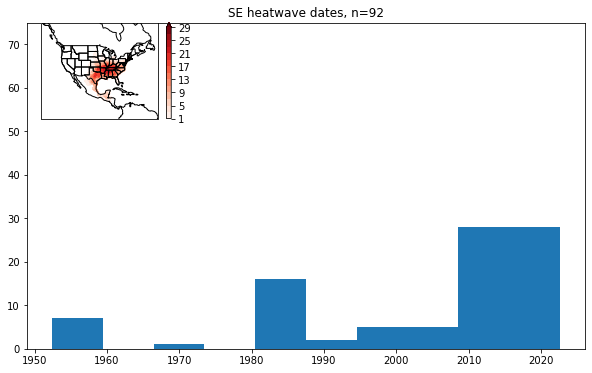

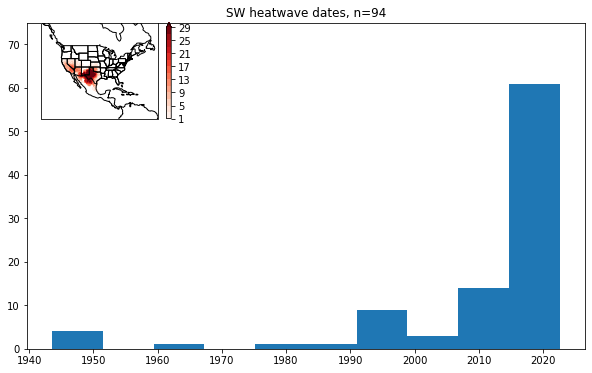

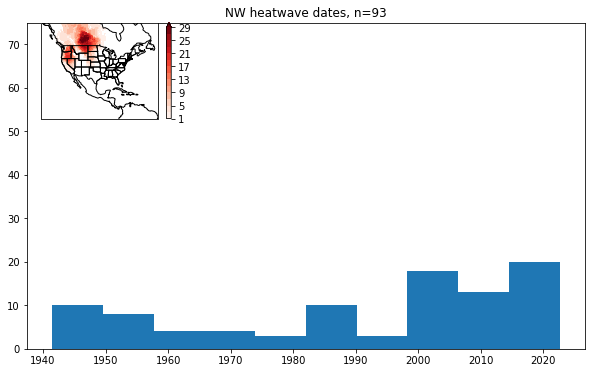

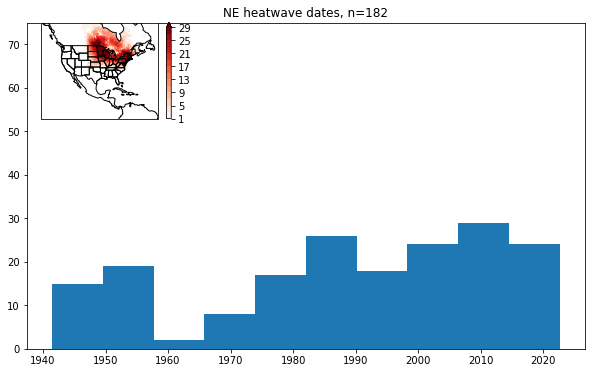

In [22]:
"""
Binning HWs by region
"""
SE_masks = []
SE_dates = []

SW_masks = []
SW_dates = []

NE_masks = []
NE_dates = []

NW_masks = []
NW_dates = []

field[np.where(field > 0)] = 1
field[np.isnan(field)] = 0
for i in range(len(pd_dates)):
    lat = cent_lats[i]
    lon = cent_lons[i]
    #SOUTHEAST
    if lat < 39 and lon > -100:
        SE_masks.append(field[i])
        SE_dates.append(pd_dates[i])
        
    #NORTHEAST
    if lat > 39 and lon > -100:
        NE_masks.append(field[i])
        NE_dates.append(pd_dates[i])
    
    #NORTHWEST
    if (lat > 39 and lon < -100):
        NW_masks.append(field[i])
        NW_dates.append(pd_dates[i])
    
    #SOUTHWEST
    if lat < 39 and lon < -100:
        SW_masks.append(field[i])
        SW_dates.append(pd_dates[i])
print(len(SW_masks))
print(len(NW_masks))
print(len(NE_masks))
print(len(SE_masks))

#SE MASKS
fig = plt.figure(figsize=(10, 6))
plt.hist(SE_dates)
plt.title("SE heatwave dates, n=" + str(len(SE_masks)))
plt.ylim(0,75)
ax = fig.add_subplot(3,3, 1, projection=ccrs.Mercator())
ax.add_feature(cfeature.STATES)
ax.coastlines()
ax.set_extent([-140, -50, 0, 50])
cf = ax.contourf(lons, lats,  np.sum(SE_masks, axis = 0), cmap='Reds',levels=np.arange(1,30, 2), extend = 'max', transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf)
#ax.add_title("Heat Wave Day Frequency by Location, 1940 - 2022")

#SW MASKS
fig = plt.figure(figsize=(10, 6))
plt.hist(SW_dates)
plt.title("SW heatwave dates, n=" + str(len(SW_masks)))
plt.ylim(0,75)
ax = fig.add_subplot(3,3,1, projection=ccrs.Mercator())
ax.add_feature(cfeature.STATES)
ax.coastlines()
ax.set_extent([-140, -50, 0, 50])
cf = ax.contourf(lons, lats,  np.sum(SW_masks, axis = 0), cmap='Reds',levels=np.arange(1,30, 2), extend = 'max', transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf)

#SW MASKS
fig = plt.figure(figsize=(10, 6))
plt.hist(NW_dates)
plt.title("NW heatwave dates, n=" + str(len(NW_masks)))
plt.ylim(0,75)
ax = fig.add_subplot(3,3,1, projection=ccrs.Mercator())
ax.add_feature(cfeature.STATES)
ax.coastlines()
ax.set_extent([-140, -50, 0, 50])
cf = ax.contourf(lons, lats,  np.sum(NW_masks, axis = 0), cmap='Reds',levels=np.arange(1,30, 2), extend = 'max', transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf)

#NE MASKS
fig = plt.figure(figsize=(10, 6))
plt.hist(NE_dates)
plt.title("NE heatwave dates, n=" + str(len(NE_masks)))
plt.ylim(0,75)
ax = fig.add_subplot(3,3, 1, projection=ccrs.Mercator())
ax.add_feature(cfeature.STATES)
ax.coastlines()
ax.set_extent([-140, -50, 0, 50])
cf = ax.contourf(lons, lats,  np.sum(NE_masks, axis = 0), cmap='Reds',levels=np.arange(1,30, 2), extend = 'max', transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf)

np.save("se_dates", SE_dates)
np.save("ne_dates", NE_dates)
np.save("sw_dates", SW_dates)
np.save("nw_dates", NW_dates)